# Цель проекта: Определение стоимости автомобилей / Project Goal: Determining the value of cars.

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

ENG:
The used car sales service "Not beaten, not painted" is developing an application to attract new customers. With it, you can quickly find out the market value of your car. You have historical data at your disposal: technical specifications, configurations, and car prices. You need to build a model to determine the value.

The client is concerned with:

- prediction quality;
- prediction speed;
- training time.


In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.6/98.6 MB 11.0 MB/s eta 0:00:00


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## ЧАСТЬ 1 : Подготовка данных / Data preparation

### Загружаем библиотеки / Loading libraries



In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import time
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor,DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder,OrdinalEncoder,StandardScaler
from sklearn.model_selection import train_test_split,GridSearchCV,RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_transformer,ColumnTransformer
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import SelectKBest, f_regression,f_classif
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor


### Загружаем данные и получаем первичную иформацию / We load the data and get the primary information

In [5]:
df=pd.read_csv('/content/drive/MyDrive/учеба/project/autos.csv')


In [6]:
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [8]:
df.shape

(354369, 16)

In [9]:
df.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


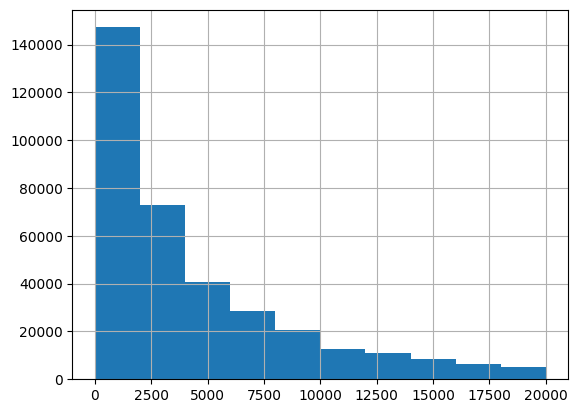

In [10]:
df['Price'].hist();

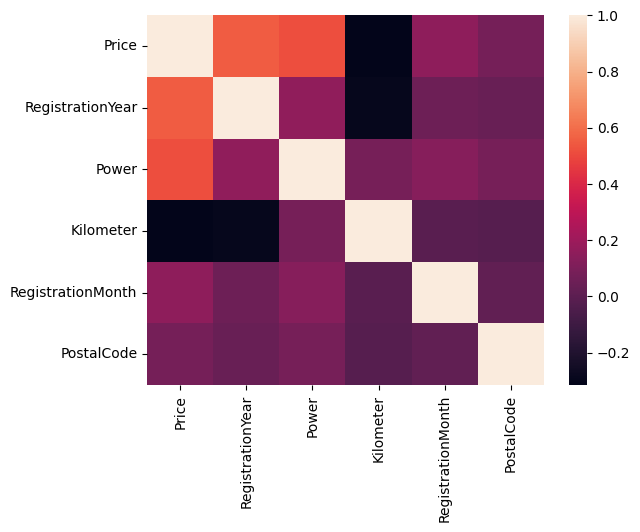

In [11]:
sns.heatmap(df[[i for i in df.columns if i!='NumberOfPictures']].corr(method='spearman'));

### Переведем часть признаков в другой формат / Let's translate some of the features into another format

In [12]:
for i in ['PostalCode','Brand','Model','VehicleType','Gearbox']:
    df[i]=df[i].astype("category")
for i in ['LastSeen','DateCrawled','DateCreated']:
    df[i]=pd.to_datetime(df[i],format='%Y-%m-%d %H:%M:%S')

### Проверим на пропуски и дубликаты / Let's check for omissions and duplicates

Stored 'ax' (Axes)


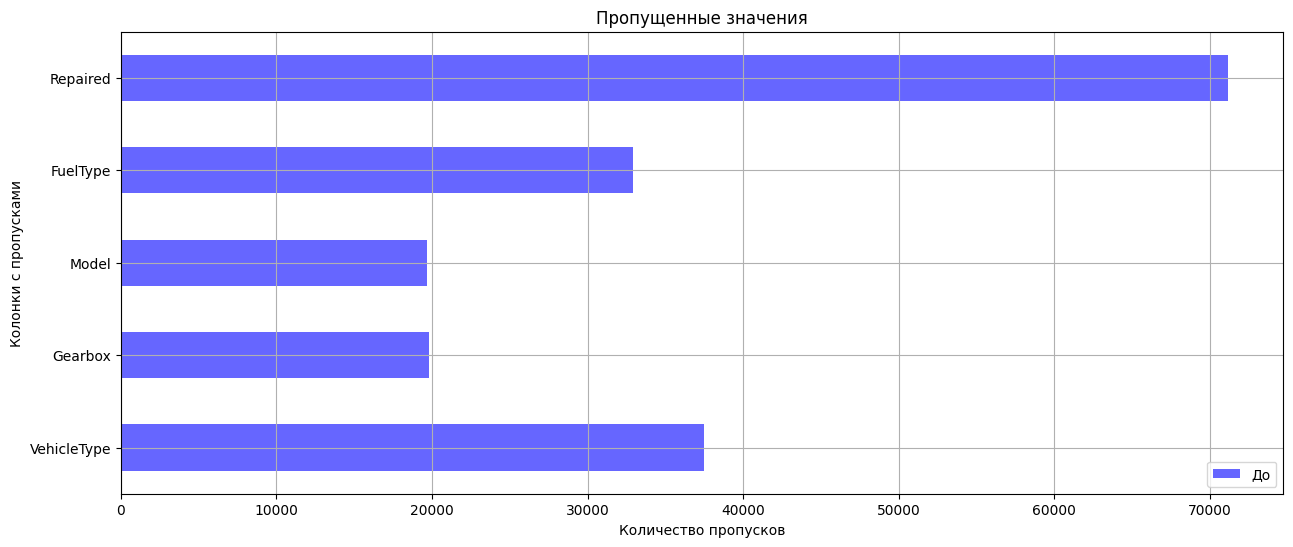

In [13]:
missing_values = df.isna().sum()

missing_columns = missing_values[missing_values > 0]



ax = missing_columns.plot(kind='barh', figsize=(15, 6), grid=True, color='b', alpha=0.6, label='До')

plt.title('Пропущенные значения')
plt.ylabel('Колонки с пропусками')
plt.xlabel('Количество пропусков')
plt.legend()
%store ax

In [14]:
print('Количество дубликатов',df.duplicated().sum())

Количество дубликатов 4


### Вывод / Conclusion

По первичным данным которые мы можем увидеть,можно сделать вывод что у нас достаточно крупная выборка,у которой много пропусков,типы данных в большинстве случаев категориальные и численные.Целевая переменная имеет асиметричное распредление.Так же можем увидеть сильную взаимосвязь у несколкьих признаков с целевой переенной это дата регистрации и мощность.Последовательность действий:
* Убирем аномальные значения
* Для востановления пропусков я создам функцию с простой моделькой которая сможет предсказать пропуски и заменить их
* Оставшиеся пропуски заменю рядом стоящими значениями
* Дубликаты из за незначительного количества просто удалю
* После этих действий изменю типы данных у некоторых признаков,часть из них удалю,а часть наоборот преобразую.

ENG: 
Based on the initial data we can see, it can be concluded that we have a fairly large sample, with many missing values. The data types in most cases are categorical and numerical. The target variable has an asymmetric distribution. We can also see a strong correlation of a few features with the target variable, namely the registration date and power. Here's the sequence of actions:

* Remove anomalous values
* To recover missing data, I will create a function with a simple model that can predict and replace missing values
* Remaining missing values will be replaced by neighboring values
* I will simply delete duplicates due to their insignificant quantity
* After these actions, I will change the data types of some features, delete some of them, and transform some others.

## ЧАСТЬ 2 : Обработка пропусков / Missing Data Handling

In [15]:
df=df.loc[(df['RegistrationYear']<2016) & (df['RegistrationYear']>1910) ]
df=df.loc[df['Price']>10]
df=df.loc[df['Power']>1]

In [16]:
def missing(data,features,target):# Функция замены пропусков
    
    columns = [i for i in features]
    
    
    new_data = data.loc[(-data[target].isna())&(-data[columns[0]].isna())&(-data[columns[1]].isna())&
                   (-data[columns[2]].isna())&(-data[columns[3]].isna()),features+[target]]

    predict = data.loc[(data[target].isna())&(-data[columns[0]].isna())&(-data[columns[1]].isna())&
                   (-data[columns[2]].isna())&(-data[columns[3]].isna()),features]
    
    
    
    features=new_data.drop(target,axis=1)
    
    target=new_data[target]
    
    label=LabelEncoder()
    
    targets=label.fit_transform(target)
    
    
    encoder=OrdinalEncoder()
    
    new_transform=encoder.fit_transform(np.concatenate((features,predict),axis=0))
    
    features=new_transform[:new_data.shape[0]]
    
    predict=new_transform[new_data.shape[0]:]
    
    param={'max_depth':range(4,20,2)}
    
    
    
    
    grid=RandomizedSearchCV(DecisionTreeClassifier(),param,cv=3)
    grid.fit(features,targets)
    predict=grid.predict(predict)
    print(f'Точность модели при заполнении признака  :{grid.best_score_}')
    return label.inverse_transform(np.round(predict))

### Заменяем пропуски / Replacing Missing Data

In [17]:
df.loc[(df['Repaired'].isna())&(-df['Gearbox'].isna())&(-df['RegistrationYear'].isna())&
                   (-df['Brand'].isna())&(-df['Kilometer'].isna()),'Repaired']=missing(df,['Gearbox','Brand','Kilometer','RegistrationYear'],'Repaired')

df.loc[(df['Model'].isna())&(-df['Gearbox'].isna())&(-df['RegistrationYear'].isna())&
                   (-df['Brand'].isna())&(-df['VehicleType'].isna()),'Model']=missing(df,['Gearbox','Brand','VehicleType','RegistrationYear'],'Model')

df.loc[(df['Gearbox'].isna())&(-df['Model'].isna())&(-df['RegistrationYear'].isna())&
                   (-df['Brand'].isna())&(-df['VehicleType'].isna()),'Gearbox']=missing(df,['Model','Brand','VehicleType','RegistrationYear'],'Gearbox')

df.loc[(df['VehicleType'].isna())&(-df['Gearbox'].isna())&(-df['RegistrationYear'].isna())&
                   (-df['Brand'].isna())&(-df['Model'].isna()),'VehicleType']=missing(df,['Gearbox','Brand','Model','RegistrationYear'],'VehicleType')

df.loc[(df['FuelType'].isna())&(-df['Gearbox'].isna())&(-df['RegistrationYear'].isna())&
                   (-df['Brand'].isna())&(-df['Model'].isna()),'FuelType']=missing(df,['Gearbox','Brand','Model','RegistrationYear'],'FuelType')

Точность модели при заполнении признака  :0.8889257939207336
Точность модели при заполнении признака  :0.664933889587886
Точность модели при заполнении признака  :0.8541745216884838
Точность модели при заполнении признака  :0.6936737215377692
Точность модели при заполнении признака  :0.7851682185952925


In [18]:
df['FuelType']=df.groupby(['Brand','RegistrationYear','Model'])['FuelType'].apply(lambda x: x.ffill().bfill())
df['VehicleType']=df.groupby(['Brand','Model','RegistrationYear'])['VehicleType'].apply(lambda x: x.ffill().bfill())
df['Gearbox']=df.groupby(['Brand','Model','RegistrationYear'])['Gearbox'].apply(lambda x: x.ffill().bfill())

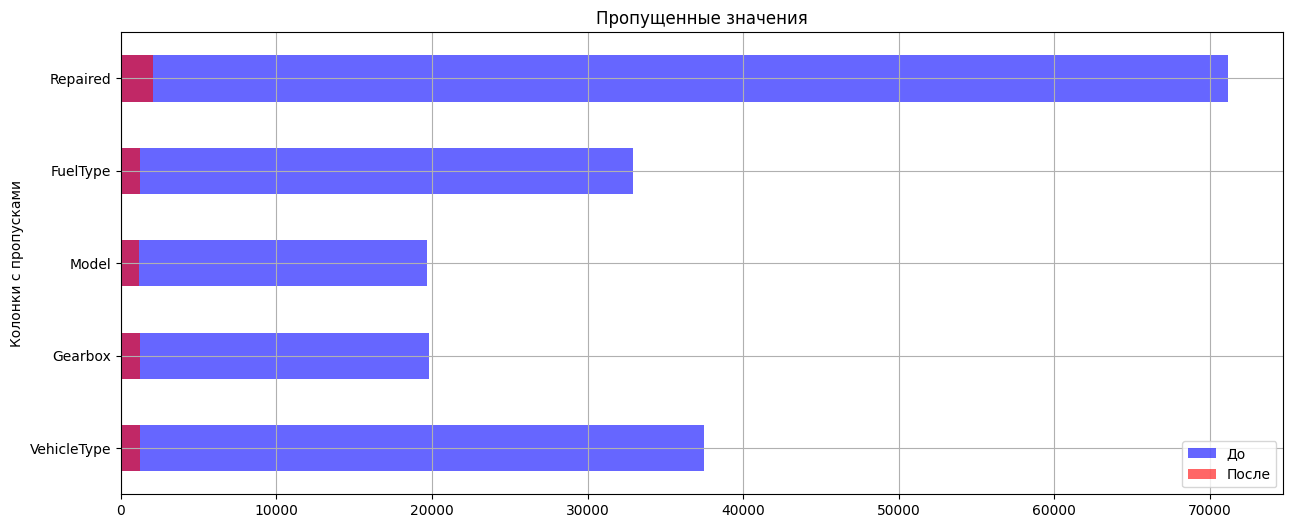

In [19]:
%store -r ax

new_missing_values = df.isna().sum()
new_missing_columns = new_missing_values[new_missing_values > 0]

new_missing_columns.plot(kind='barh', grid=True, color='r', alpha=0.6, ax=ax, label='После')

ax.legend()

plt.show()


In [20]:
df.shape

(289816, 16)

### Вывод / Conclusion
Как мы видим количесвто пропсуков значительно сократилось,в связи с чем мы можем оставшиеся удалить. / 
As we can see, the number of missing values has significantly decreased, allowing us to delete the remaining ones.

In [21]:
df=df.dropna()
df=df.drop_duplicates()

In [22]:
print(f'Количество пропусков : {df.isna().sum()}')
print()
print(f'Количество lдубликатов : {df.duplicated().sum()}')

Количество пропусков : DateCrawled          0
Price                0
VehicleType          0
RegistrationYear     0
Gearbox              0
Power                0
Model                0
Kilometer            0
RegistrationMonth    0
FuelType             0
Brand                0
Repaired             0
DateCreated          0
NumberOfPictures     0
PostalCode           0
LastSeen             0
dtype: int64

Количество lдубликатов : 0


## ЧАТЬ 3 :  Работа с признаками / Work with features

### Создание новых признаков / Create new features

In [23]:
df['how_long']=(df['LastSeen']-df['DateCreated']).astype('timedelta64[D]')

df['year_created']=(pd.DatetimeIndex(df['DateCreated']).year).astype("category")

df['month_created']=pd.DatetimeIndex(df['DateCreated']).month.astype("category")

df['Repaired']=np.where(df['Repaired']=='yes',1,0)
for i in ['RegistrationYear','FuelType','Repaired']:
    df[i]=df[i].astype("category")

### Удаление не нужных признаков / Removing unnecessary features

In [24]:
df=df.drop(['DateCrawled','RegistrationMonth','DateCreated','LastSeen','NumberOfPictures'],axis=1)

In [25]:
print(df.duplicated().sum())
df=df.drop_duplicates()

10303


In [26]:
for column in df.columns:
    counts = df[column].value_counts()  
    categories_to_keep = counts[counts > 10].index  
    df = df[df[column].isin(categories_to_keep)] 

### Анализ

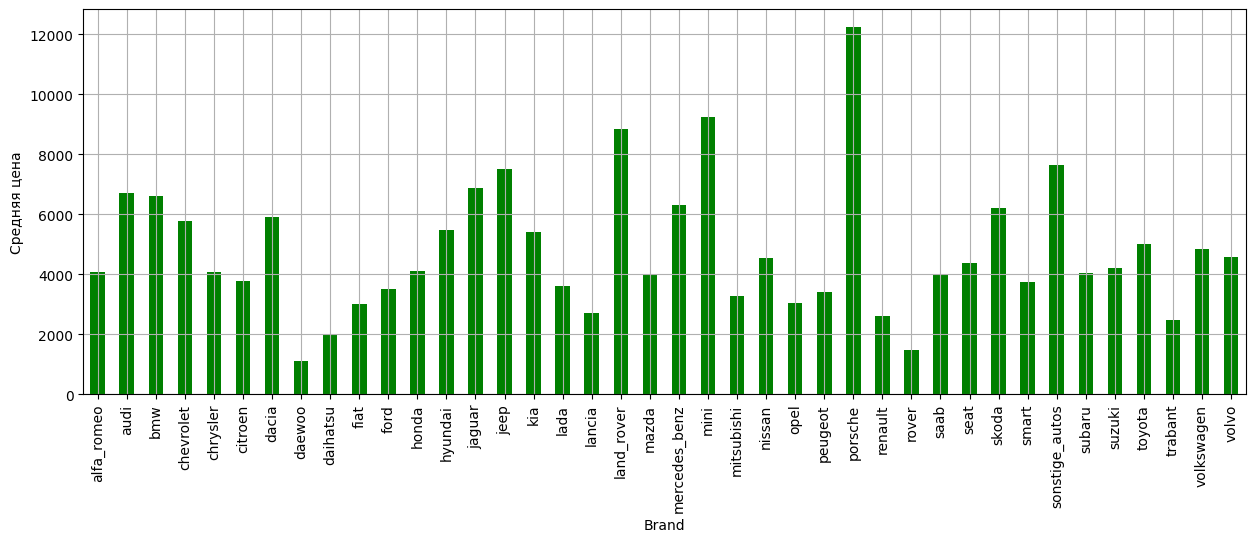

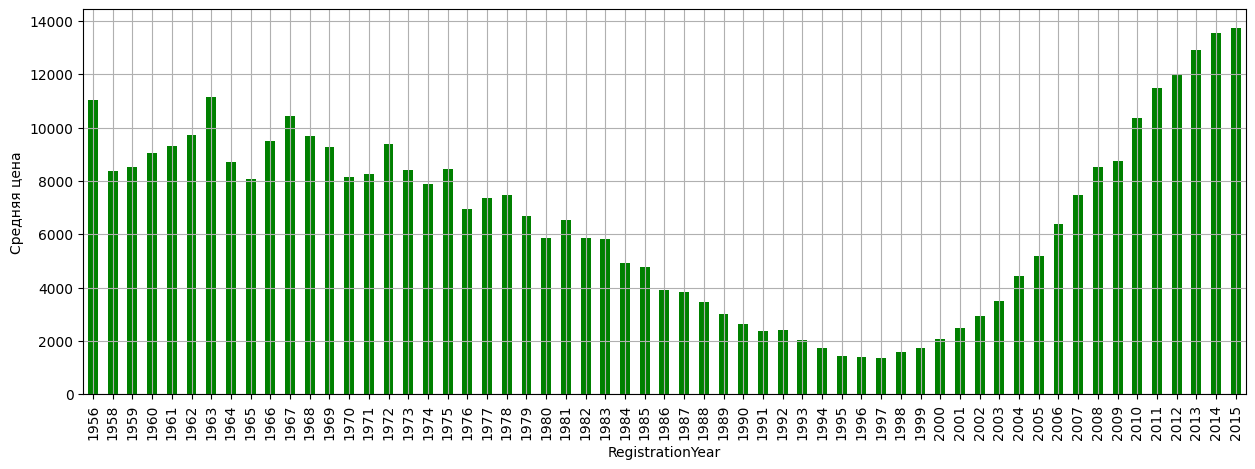

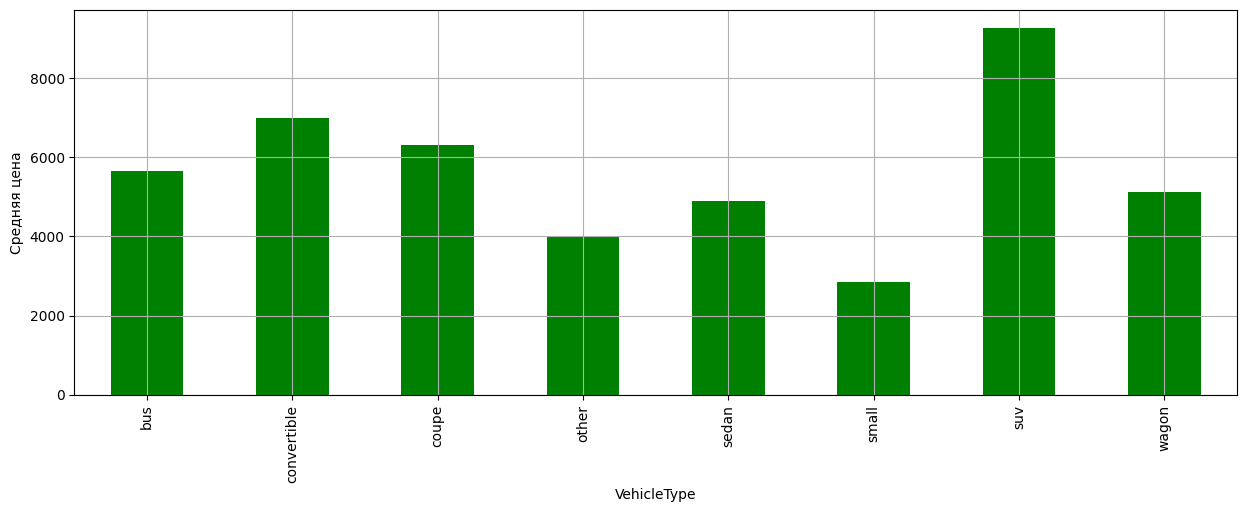

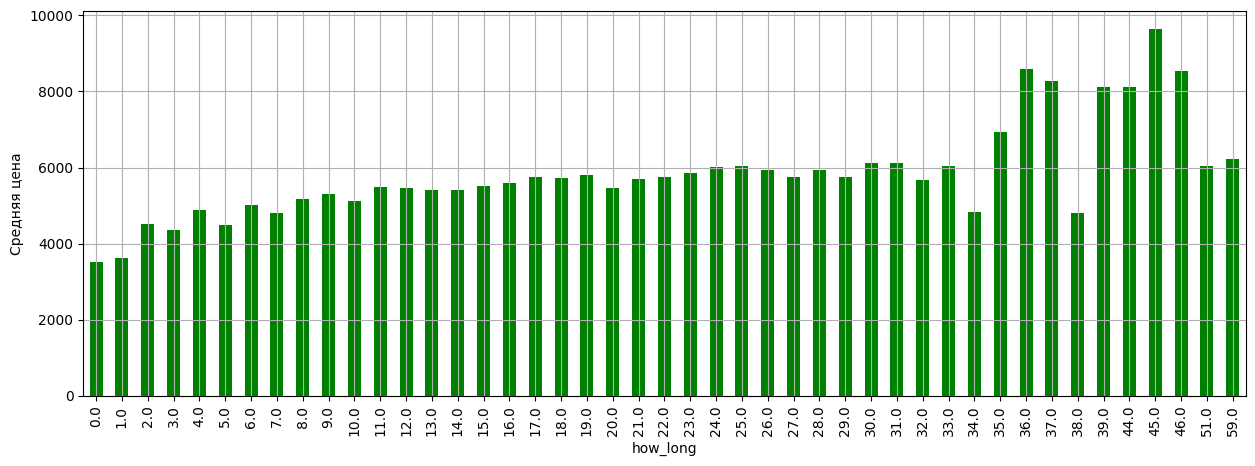

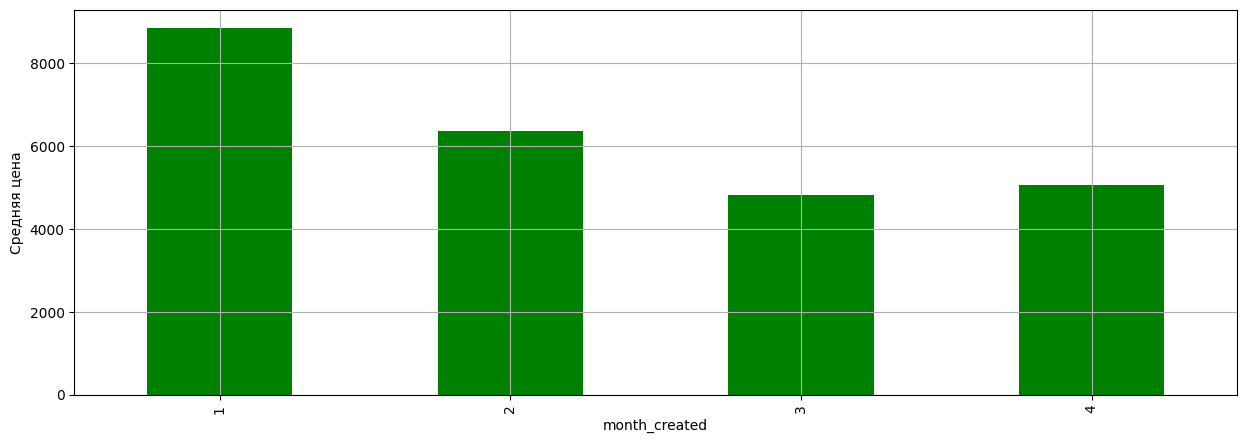

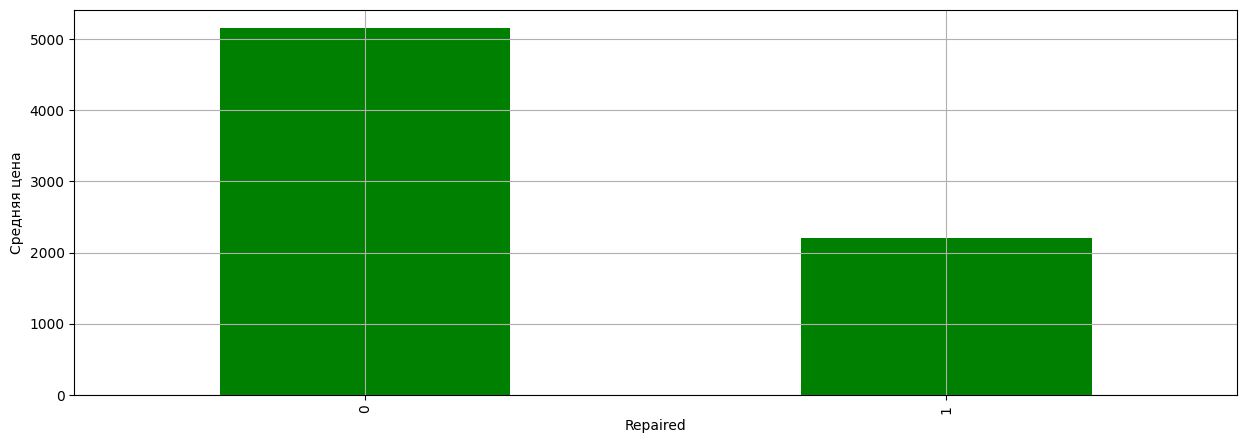

In [27]:
for i in ['Brand','RegistrationYear','VehicleType','how_long','month_created','Repaired']:
    
    df.pivot_table(index=i,values='Price',aggfunc='mean').plot(kind='bar',figsize=(15,5),color='g',grid=True,legend=False)
    plt.xlabel(i)
    plt.ylabel('Средняя цена')
    
    plt.show()


### Вывод / Conclusion 

После небольшого анализа ,мы можем увидеть что некоторые признаки отличаються по цене,конечно большинство из них вполне логичны,но и опять же эти графики дают представление об общей картине.Что ороже стоят машины которые не были биты премиальных брендов,так же можем увидеть что быстрее продаються машины дешовые,так же моно понять что все старые машины это какой то дорогой раритет так как стоимость большая а дата регистрации очень старая,так же можем понять в какие месяца какой тип машин продаеться.

ENG:

After a brief analysis, we can see that some features vary in price, most of which are quite logical. Yet again, these graphs provide an overview of the general picture. More expensive cars are those that haven't been damaged and belong to premium brands. We can also see that cheaper cars sell faster. Additionally, it can be understood that all old cars are some sort of expensive rarity since the cost is high and the registration date is very old. We can also understand in which months certain types of cars are sold.


## ЧАСТЬ 4 Обучение моделей / Learning models

### Выделим признаки и целевой признак / Let's highlight the signs and the target attribute

In [28]:
features=df.drop(['Price','how_long','year_created', 'month_created'],axis=1)
target=df['Price']



features_train,fetures_test,target_train,target_test=train_test_split(features,target,test_size=0.25,random_state=345,shuffle=target)

pre=make_column_transformer((OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1),[i for i in features.columns  if features[i].dtype !='int']),
                            (StandardScaler(),[i for i in features.columns  if features[i].dtype =='int' and i!='Price']))



In [29]:
time_model=[]
RMSE=[]


In [30]:
features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 255190 entries, 1 to 354368
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype   
---  ------            --------------   -----   
 0   VehicleType       255190 non-null  category
 1   RegistrationYear  255190 non-null  category
 2   Gearbox           255190 non-null  category
 3   Power             255190 non-null  int64   
 4   Model             255190 non-null  category
 5   Kilometer         255190 non-null  int64   
 6   FuelType          255190 non-null  category
 7   Brand             255190 non-null  category
 8   Repaired          255190 non-null  category
 9   PostalCode        255190 non-null  category
dtypes: category(8), int64(2)
memory usage: 8.6 MB


### Создадим функцию и обучим несколько моделей. / Create study function and leanr some models
* Так же я решил использовать SelectKBest так как у нас достаточно большая выборка а исходя их данных которые у нас были ранее можно ограничить чать признаков для того что бы обучении проходило быстрее
* Изначально я хотел использовать полностью конвеер без функции но так как нам нужно еще учесть и время обучения какждой модели решил разюить все отдельно.

ENG 
* I also decided to use SelectKBest because we have a fairly large sample, and based on the data we had previously, we can limit some features to speed up training.
* Initially, I wanted to use the pipeline completely without a function, but since we also need to take into account the training time of each model, I decided to run everything separately.

In [31]:
def study(features,target,param,model):
    
    
    
    feature_selection = SelectKBest(score_func=f_regression)

    pipeline = Pipeline([('preprocesing',pre),
     ('selection',feature_selection),('model',model)])
    

    grid = RandomizedSearchCV(pipeline, param, cv=5,scoring='neg_root_mean_squared_error')
    grid.fit(features, target)
    
    print('RMSE:', grid.best_score_)
    return grid

In [32]:


start_time = time.time()
cat=(study(features_train,target_train,{'selection__k': [3, 6, 10],'model__learning_rate':[0.01,0.1,1],'model__l2_leaf_reg': [0.1, 1, 10],'model__n_estimators': [100, 500, 100],'model__depth':[4,6,8]},CatBoostRegressor(verbose=False)))
RMSE.append(cat.best_score_)
end_time = time.time()
time_model.append(end_time-start_time)


RMSE: -1598.1637607964217


In [33]:

start_time = time.time()
forest=(study(features_train,target_train,{'selection__k': [3, 6, 10],'model__n_estimators': range(10,70,20),'model__max_depth': [4, 6, 8],'model__min_samples_split': [2, 4, 8]},RandomForestRegressor(random_state=1224)))
RMSE.append(forest.best_score_)
end_time = time.time()
time_model.append(end_time-start_time)

RMSE: -2029.5048532713445


In [34]:
start_time = time.time()
light=(study(features_train,target_train,{'selection__k': [3, 6, 10],'model__learning_rate': [0.01, 0.1, 1],'model__num_leaves': [32, 64, 128],'model__max_depth': [4, 6, 8]},LGBMRegressor()))
RMSE.append(light.best_score_)
end_time = time.time()
time_model.append(end_time-start_time)

RMSE: -1648.454505015914


In [35]:
start_time = time.time()
tree=(study(features_train,target_train,{'selection__k': [3, 6, 10],'model__max_depth': range(3,10),'model__min_samples_split': [2, 4, 8]},DecisionTreeRegressor()))
RMSE.append(tree.best_score_)
end_time = time.time()
time_model.append(end_time-start_time)

RMSE: -2082.451384588143


In [36]:
def predict_time(model,features):
  start_time = time.time()
  model.predict(features)
  end_time = time.time()
  return (end_time-start_time)

## Анализ моделей / Model analysis

In [37]:
models=pd.DataFrame({'Time':time_model,'RMSE':(RMSE)},index=['CatBoost','RandomForest','LightGBM','DecisionTree'])
models['RMSE']=models['RMSE']*-1
models

,Time,RMSE
CatBoost,178.164520,1598.163761
RandomForest,105.271578,2029.504853
LightGBM,73.644401,1648.454505
DecisionTree,23.498674,2082.451385


CatBoost        178.164520
RandomForest    105.271578
LightGBM         73.644401
DecisionTree     23.498674
dtype: float64

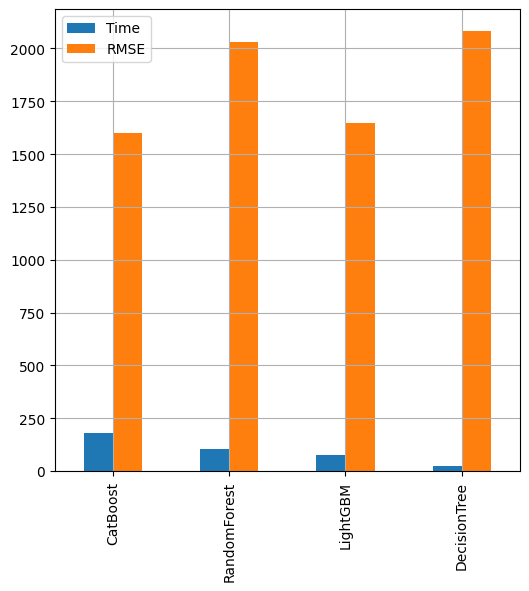

In [38]:
models.plot(kind='bar',grid=True,figsize=(6,6))
pd.Series(time_model,index=['CatBoost','RandomForest','LightGBM','DecisionTree'])

<Axes: >

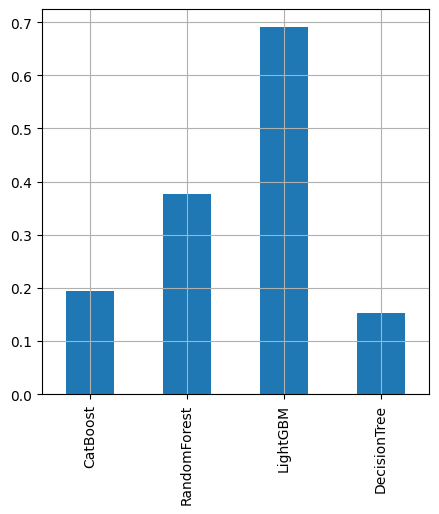

In [40]:
predict_t=pd.Series([predict_time(i,fetures_test) for i in [cat,forest,light,tree]],index=['CatBoost','RandomForest','LightGBM','DecisionTree'])
predict_t.plot(kind='bar',grid=True,figsize=(5,5))

### Вывод / Conclusion

Мы видим что модель CatBoost показывает лучший показатель в метрике RMSE ,но модель самая долгая ,если искать лучший показать по времени то это определенно Древо решений ,но метрика RMSE одна из самых худших хотя и удовлетворяет условие,но если брать что то среднее между качеством и временем то LightGBMR подходит лучше всего он показывает и относительно хороший показтель метрики и скорость своего обучения.В связи с этим мы остановимся на этой модели,осталось проверить на переобученность .

ENG:

We see that the CatBoost model shows the best performance in the RMSE metric, but it's the slowest model. If we are looking for the best performance in terms of time, then definitely the Decision Tree is the winner, but its RMSE metric is one of the worst, even though it meets the requirement. However, if we're looking for a balance between quality and time, then LightGBM fits the best. It shows relatively good performance in terms of the metric and its training speed. With this in mind, we will settle on this model, the remaining task is to check for overfitting.

In [42]:
print(f'RMSE модели с обучающими данными : {light.best_score_}')
print(f'RMSE модели с тестовыми данными : {np.sqrt(mean_squared_error(target_test,light.predict(fetures_test)))}')

RMSE модели с обучающими данными : -1648.454505015914
RMSE модели с тестовыми данными : 1632.912298471819


Мы видим что разницы практически нету в связи с этим окончательно выбираем данную модель / We see that there is practically no difference in this regard, we finally choose this model